In [1]:
import os
import math

import pretty_midi
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder

from scipy.io import wavfile
from python_speech_features import mfcc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator

[2023-07-25 22:27:15,271] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-07-25 22:27:15.597758: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 22:27:16.037281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
raw_data_folder = 'data/AAI511_final_project/'

In [ ]:
def preprocess_midi_into_mel_and_mfcc(midi_file, segment_length=2000, num_cepstral=13):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    audio_data = midi_data.synthesize()
    wavfile.write("temp.wav", 44100, audio_data.astype(np.float32))

    audio, rate = librosa.load("temp.wav")
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=rate)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    mfcc_features = mfcc(audio, samplerate=rate, numcep=num_cepstral, winlen=0.025, winstep=0.01, nfft=1103)

    # Truncate or pad the spectrogram and MFCC features
    min_length = min(spectrogram_db.shape[1], mfcc_features.shape[0])
    if min_length % segment_length != 0:
        min_length = min_length - (min_length % segment_length)

    segments = []
    for start in range(0, min_length - segment_length + 1, segment_length):
        mel_segment = spectrogram_db[:, start:start + segment_length]
        mfcc_segment = mfcc_features[start:start + segment_length, :]
        segments.append((mel_segment, mfcc_segment))

    os.remove("temp.wav")

    return segments

In [ ]:
def preprocess_data_in_directory(base_dir):
    X = []
    y = []
    X_mel = []
    X_mfcc = []

    # to show progression
    total_files = sum([len(files) for r, d, files in os.walk(base_dir)])
    processed_files = 0

    composers = os.listdir(base_dir)
    for composer in composers:
        composer_dir = os.path.join(base_dir, composer)
        if os.path.isdir(composer_dir):
            for file in os.listdir(composer_dir):
                if file.endswith('.mid'):
                    file_path = os.path.join(composer_dir, file)
                    try:
                      segments = preprocess_midi_into_mel_and_mfcc(file_path)

                      for mel_segment, mfcc_segment in segments:
                        X_mel.append(mel_segment)
                        X_mfcc.append(mfcc_segment)
                        y.append(composer)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
                    processed_files += 1
                    if processed_files % (total_files // 10) == 0:
                      print(f"Processed {processed_files / total_files * 100}% of files")
    return np.array(X_mel), np.array(X_mfcc), np.array(y)

In [ ]:
X_train_mel, X_train_mfcc, y_train = preprocess_data_in_directory(raw_data_folder + 'train', preprocess_type='both')
X_test_mel, X_test_mfcc, y_test = preprocess_data_in_directory(raw_data_folder + 'test', preprocess_type='both')
X_dev_mel, X_dev_mfcc, y_dev = preprocess_data_in_directory(raw_data_folder + 'dev', preprocess_type='both')

/home/jthomas/Documents/AAI510/final-project/venv/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processed 9.762532981530343% of files
Processed 19.525065963060687% of files
Processed 29.287598944591032% of files
Processed 39.050131926121374% of files
Processed 48.812664907651715% of files
Processed 58.575197889182064% of files
Processed 68.33773087071239% of files
Processed 78.10026385224275% of files
Processed 87.86279683377309% of files
Processed 8.88888888888889% of files
Processed 17.77777777777778% of files
Processed 26.666666666666668% of files
Processed 35.55555555555556% of files
Processed 44.44444444444444% of files
Processed 53.333333333333336% of files
Processed 62.22222222222222% of files
Processed 71.11111111111111% of files
Processed 8.88888888888889% of files
Processed 17.77777777777778% of files
Processed 26.666666666666668% of files
Processed 35.55555555555556% of files
Processed 44.44444444444444% of files
Processed 53.333333333333336% of files
Processed 62.22222222222222% of files
Processed 71.11111111111111% of files


In [ ]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_dev = le.transform(y_dev)

class_list = le.classes_

In [ ]:
# Get unique values and their counts
unique_values, counts = torch.unique(y_train, return_counts=True)

# Print unique values and their counts
for value, count in zip(unique_values, counts):
    print(f'{value}: {count}')

0.0: 234
1.0: 111
2.0: 194
3.0: 221
4.0: 197
5.0: 500
6.0: 227
7.0: 425
8.0: 265


In [ ]:
X_train_mel = torch.from_numpy(X_train_mel).float()
X_train_mfcc = torch.from_numpy(X_train_mfcc).float()

X_train_mel = X_train_mel.unsqueeze(1)
X_train_mfcc = X_train_mfcc.unsqueeze(1)

y_train = torch.from_numpy(y_train).float()

X_test_mel = torch.from_numpy(X_test_mel).float()
X_test_mfcc = torch.from_numpy(X_test_mfcc).float()

X_test_mel = X_test_mel.unsqueeze(1)
X_test_mfcc = X_test_mfcc.unsqueeze(1)

y_test = torch.from_numpy(y_test).float()

X_dev_mel = torch.from_numpy(X_dev_mel).float()
X_dev_mfcc = torch.from_numpy(X_dev_mfcc).float()

X_dev_mel = X_dev_mel.unsqueeze(1)
X_dev_mfcc = X_dev_mfcc.unsqueeze(1)

y_dev = torch.from_numpy(y_dev).float()

In [293]:
mean_mel = X_train_mel.mean()
std_mel = X_train_mel.std()

mean_mfcc = X_train_mfcc.mean()
std_mfcc = X_train_mfcc.std()

In [294]:
X_train_mel = (X_train_mel - mean_mel) / std_mel
X_train_mfcc = (X_train_mfcc - mean_mfcc) / std_mfcc

X_dev_mel = (X_dev_mel - mean_mel) / std_mel
X_dev_mfcc = (X_dev_mfcc - mean_mfcc) / std_mfcc

X_test_mel = (X_test_mel - mean_mel) / std_mel
X_test_mfcc = (X_test_mfcc - mean_mfcc) / std_mfcc

In [295]:
torch.save(X_train_mel, raw_data_folder + 'X_train_mel.pt')
torch.save(X_train_mfcc, raw_data_folder + 'X_train_mfcc.pt')
torch.save(y_train, raw_data_folder + 'y_train.pt')
torch.save(X_test_mel, raw_data_folder + 'X_test_mel.pt')
torch.save(X_test_mfcc, raw_data_folder + 'X_test_mfcc.pt')
torch.save(y_test, raw_data_folder + 'y_test.pt')
torch.save(X_dev_mel, raw_data_folder + 'X_dev_mel.pt')
torch.save(X_dev_mfcc, raw_data_folder + 'X_dev_mfcc.pt')
torch.save(y_dev, raw_data_folder + 'y_dev.pt')

In [3]:
X_train_mel = torch.load(raw_data_folder + 'X_train_mel.pt')
X_train_mfcc = torch.load(raw_data_folder + 'X_train_mfcc.pt')
y_train = torch.load(raw_data_folder + 'y_train.pt')

X_test_mel = torch.load(raw_data_folder + 'X_test_mel.pt')
X_test_mfcc = torch.load(raw_data_folder + 'X_test_mfcc.pt')
y_test = torch.load(raw_data_folder + 'y_test.pt')

X_dev_mel = torch.load(raw_data_folder + 'X_dev_mel.pt')
X_dev_mfcc = torch.load(raw_data_folder + 'X_dev_mfcc.pt')
y_dev = torch.load(raw_data_folder + 'y_dev.pt')

In [4]:
class_list = []
composers = os.listdir(raw_data_folder + 'train')
for composer in composers:
  class_list.append(composer)
class_list = class_list[:-1]

In [5]:
class_list

['mozart',
 'bach',
 'mendelssohn',
 'handel',
 'hummel',
 'byrd',
 'chopin',
 'bartok',
 'schumann']

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_mel = X_train_mel.to(device)
X_train_mfcc = X_train_mfcc.to(device)
y_train = y_train.to(device, dtype=torch.int64)
X_test_mel = X_test_mel.to(device)
X_test_mfcc = X_test_mfcc.to(device)
y_test = y_test.to(device, dtype=torch.int64)
X_dev_mel = X_dev_mel.to(device)
X_dev_mfcc = X_dev_mfcc.to(device)
y_dev = y_dev.to(device, dtype=torch.int64)

In [236]:
def calculate_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for mel_inputs, labels in test_loader:
            mel_inputs = mel_inputs.to(device)  # Move inputs to the device
            labels = labels.to(device)  # Move labels to the device

            # Forward pass
            outputs = model(mel_inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Usage example
val_accuracy = calculate_accuracy(model, val_loader)
print(f'Validation Accuracy: {val_accuracy:.4f}')


Validation Accuracy: 0.4424


In [237]:
def create_confusion_matrix(model, test_loader, num_classes):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for mel_inputs, labels in test_loader:
            mel_inputs = mel_inputs.to(device)  # Move inputs to the device
            labels = labels.to(device)  # Move labels to the device

            # Forward pass
            outputs = model(mel_inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Create the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
    return cm

def plot_confusion_matrix(confusion_mtx, labels):
    # Normalize the confusion matrix
    confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a heatmap using seaborn
    sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)

    # Set labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

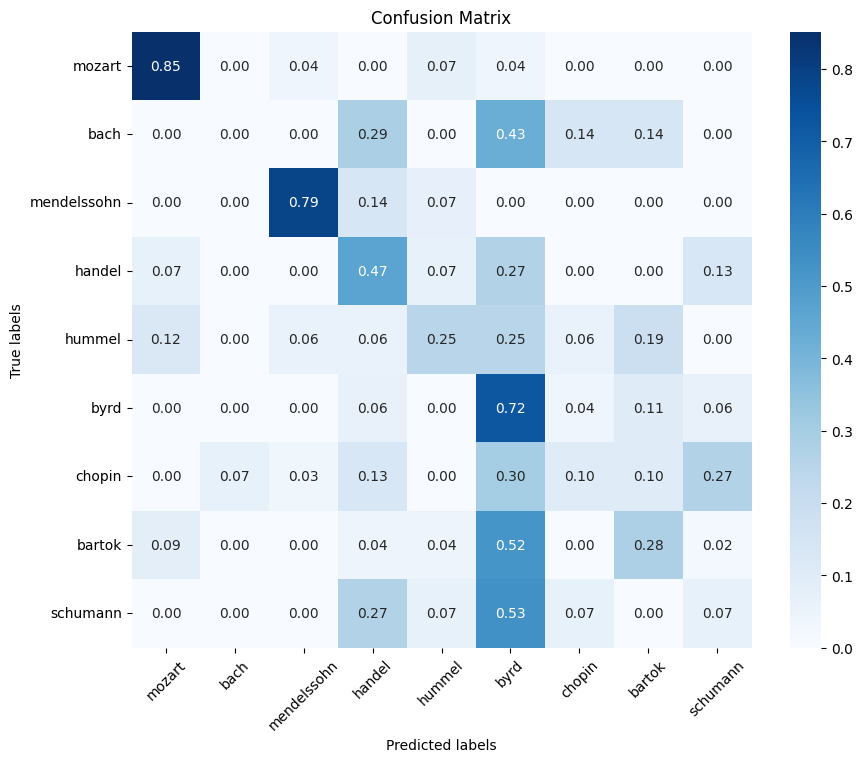

In [238]:
num_classes = len(torch.unique(y_dev))
confusion_mtx = create_confusion_matrix(model, val_loader, num_classes)
class_labels = val_loader.dataset.classes()
plot_confusion_matrix(confusion_mtx, class_labels)

In [385]:
class Mel_CNN(nn.Module):
    def __init__(self, num_classes, num_filters, dropout_rate=0.5):
        super(Mel_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 1024, kernel_size=1)
        self.bn5 = nn.BatchNorm2d(1024)

        self.fc1 = nn.Linear(1024, 128)
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        x = self.pool(nn.functional.relu(self.bn4(self.conv4(x))))
        x = self.pool(nn.functional.relu(self.bn5(self.conv5(x))))
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)  # Flatten the tensor from the convolutional layers
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return nn.functional.softmax(x, dim=1)

In [6]:
class MelDataset(Dataset):
    def __init__(self, X_mel, y, class_list):
        self.X_mel = X_mel
        self.y = y
        self.class_list = class_list

    def __len__(self):
        return len(self.X_mel)

    def __getitem__(self, idx):
        return self.X_mel[idx], self.y[idx]


    def classes(self):
        # Return the list of class labels
        return self.class_list

In [7]:
train_dataset_mel = MelDataset(X_train_mel, y_train, class_list)
test_dataset_mel = MelDataset(X_test_mel, y_test, class_list)
val_dataset_mel = MelDataset(X_dev_mel, y_dev, class_list)

In [8]:
# Define the batch size
batch_size = 32

# Create the DataLoader
train_loader_mel = DataLoader(train_dataset_mel, batch_size=batch_size, shuffle=True)
test_loader_mel = DataLoader(test_dataset_mel, batch_size=batch_size, shuffle=False)
val_loader_mel = DataLoader(val_dataset_mel, batch_size=batch_size, shuffle=False)

In [9]:
def train_mel(model, optimizer, scheduler,
                   train_loader, test_loader, num_epochs=100, patience=10):

    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_test_loss = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_iter = iter(train_loader)
        test_iter = iter(test_loader)

        for batch_idx, (mel_inputs, labels) in enumerate(train_iter):
            # Forward pass
            outputs = model(mel_inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.long()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Backward pass and optimization
            optimizer.zero_grad()
            accelerator.backward(loss)
            optimizer.step()
            train_loss += loss.item() * mel_inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        train_accuracy = train_correct / train_total
        train_accuracies.append(train_accuracy)

        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            for mel_inputs, labels in test_loader:
                # Forward pass
                outputs = model(mel_inputs)
                _, predicted = torch.max(outputs.data, 1)

                # Compute accuracy and loss
                test_loss += criterion(outputs, labels).item() * mel_inputs.size(0)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)

            test_accuracy = test_correct / test_total
            test_accuracies.append(test_accuracy)

        accuracy = 100 * test_correct / test_total
        print(f'Epoch {epoch}, train loss: {train_loss:.4f}, train accuracy: {train_accuracy:.2f}, test loss: {test_loss:.4f}, test accuracy: {test_accuracy:.2f}, learning rate: {scheduler.get_lr()[0]}')

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            print('Saving model!')
            torch.save(model.state_dict(), 'cnn_lsmt_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve in [20, 30, 40]:
                print('Stepping lr_scheduler')
                scheduler.step()
            if epochs_no_improve == patience:
                print('Early stopping!')
                break

    return train_losses, test_losses, train_accuracies, test_accuracies, best_test_loss

In [391]:
patience = 60
num_epochs = 200
lr = 0.0001
dropout_rate = 0.5
weight_decay=0.005
num_classes = len(torch.unique(y_train))
# Initialize the model
mel_model = Mel_CNN(num_classes, dropout_rate)
mel_model = mel_model.to(device)

In [392]:
optimizer = torch.optim.Adam(mel_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [393]:
accelerator = Accelerator()
mel_model, optimizer, train_loader_mel, test_loader_mel = accelerator.prepare(
mel_model, optimizer, train_loader_mel, test_loader_mel
)

In [394]:
train_losses, test_losses = train_mel(mel_model,
optimizer, scheduler, train_loader_mel, test_loader_mel, num_epochs, patience)

Epoch 0, train loss: 2.1830, train accuracy: 0.16, test loss: 2.1567, test accuracy: 0.20, learning rate: 0.0001
Saving model!
Epoch 1, train loss: 2.1369, train accuracy: 0.24, test loss: 2.0900, test accuracy: 0.36, learning rate: 0.0001
Saving model!
Epoch 2, train loss: 2.0782, train accuracy: 0.30, test loss: 2.0360, test accuracy: 0.39, learning rate: 0.0001
Saving model!
Epoch 3, train loss: 2.0460, train accuracy: 0.32, test loss: 2.0097, test accuracy: 0.38, learning rate: 0.0001
Saving model!
Epoch 4, train loss: 2.0115, train accuracy: 0.37, test loss: 2.0636, test accuracy: 0.28, learning rate: 0.0001
Epoch 5, train loss: 1.9847, train accuracy: 0.39, test loss: 2.0048, test accuracy: 0.37, learning rate: 0.0001
Saving model!
Epoch 6, train loss: 1.9604, train accuracy: 0.42, test loss: 1.9548, test accuracy: 0.43, learning rate: 0.0001
Saving model!
Epoch 7, train loss: 1.9310, train accuracy: 0.47, test loss: 1.9188, test accuracy: 0.49, learning rate: 0.0001
Saving model

In [398]:
mel_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader_mel:
        inputs = inputs.to(device)  # Move inputs to the device (e.g., GPU)
        labels = labels.to(device)  # Move labels to the device

        # Forward pass
        outputs = mel_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total

print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.6359


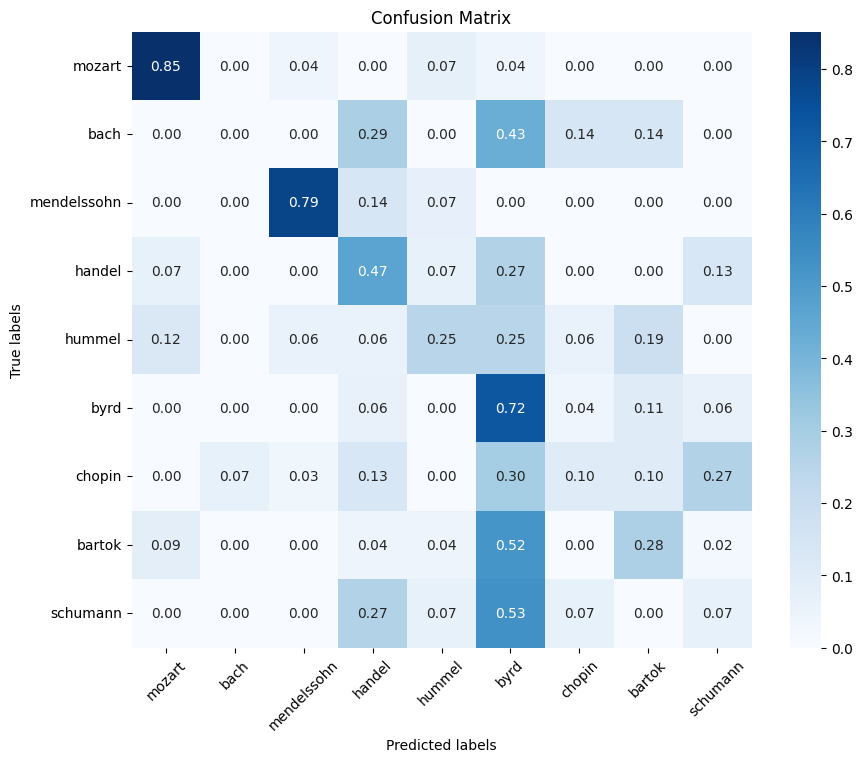

In [401]:
mel_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader_mel:
        inputs = inputs.to(device)  # Move inputs to the device (e.g., GPU)
        labels = labels.to(device)  # Move labels to the device

        # Forward pass
        outputs = mel_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))

# Normalize the confusion matrix
confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))


class_labels = val_loader.dataset.classes()
# Create a heatmap using seaborn
sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [10]:
class Mel_LSTM_CNN(nn.Module):
    def __init__(self,
                 num_classes,
                 hidden_size,
                 initial_filter=32,
                 num_lstm_layers=1,
                 num_cnn_layers=5,
                 dropout_rate=0.5):

        super(Mel_LSTM_CNN, self).__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.conv1 = nn.Conv2d(1, initial_filter, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(initial_filter)

        for n in range(num_cnn_layers - 2):
          in_channels = 2 ** n * initial_filter
          out_channels = in_channels * 2
          self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
          self.bns.append(nn.BatchNorm2d(out_channels))

        final_in_channel = 2 ** (num_cnn_layers - 2) * initial_filter
        self.final_out_channel = final_in_channel * 4
        self.convLast = nn.Conv2d(final_in_channel, self.final_out_channel, kernel_size=1)
        self.bnLast = nn.BatchNorm2d(self.final_out_channel)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(self.final_out_channel, hidden_size, num_lstm_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        for conv, bn in zip(self.convs, self.bns):
          x = self.pool(nn.functional.relu(bn(conv(x))))

        x = self.pool(nn.functional.relu(self.bnLast(self.convLast(x))))
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)  # Flatten the tensor from the convolutional layers
        x = x.view(x.size(0), -1, self.final_out_channel)
        x, _ = self.lstm(x)
        # Only take the output from the final timestep
        x = x[:, -1, :]
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return nn.functional.softmax(x, dim=1)

In [11]:
patience = 60
num_epochs = 20
num_classes = len(torch.unique(y_train))

lrs = [0.01, 0.001, 0.0001, 0.00001]
dropout_rates = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
weight_decays = [0.001, 0.005, 0.01, 0.05]
hidden_sizes = [32, 64, 128, 256, 512, 1024]
num_lstm_layer_options = [1, 2, 3]
num_cnn_layer_options = [3, 4, 5]
initial_filter_options = [8, 16, 32, 64]

In [23]:
best_loss = float('inf')
best_hyperparameters = None
hyperparameters_tested = set()

In [26]:
def run_training(train_loader_mel, test_loader_mel, num_classes, device, num_epochs, patience, accelerator):
  global hyperparameters_tested
  global best_loss
  global best_hyperparameters

  def generate_hypers():
    lr = np.random.choice(lrs)
    dropout_rate = np.random.choice(dropout_rates)
    weight_decay = np.random.choice(weight_decays)
    hidden_size = np.random.choice(hidden_sizes)
    num_lstm_layers = np.random.choice(num_lstm_layer_options)
    num_cnn_layers = np.random.choice(num_cnn_layer_options)
    initial_filter = np.random.choice(initial_filter_options)

    hyperparameters_dict = {'lr': lr, 'dropout_rate': dropout_rate, 'weight_decay': weight_decay,
                          'hidden_size': hidden_size, 'num_lstm_layers': num_lstm_layers,
                          'num_cnn_layers': num_cnn_layers, 'initial_filter': initial_filter}

    return hyperparameters_dict


  hyperparameters_dict = generate_hypers()
  while tuple(hyperparameters_dict.values()) in hyperparameters_tested:
    hyperparameters_dict = generate_hypers()

  hyperparameters_tested.add(tuple(hyperparameters_dict.values()))

  print(hyperparameters_dict)

  mel_lstm_cnn_model = Mel_LSTM_CNN(num_classes,
                                    hyperparameters_dict['hidden_size'],
                                    hyperparameters_dict['initial_filter'],
                                    hyperparameters_dict['num_lstm_layers'],
                                    hyperparameters_dict['num_cnn_layers'],
                                    hyperparameters_dict['dropout_rate'])
  mel_lstm_cnn_model = mel_lstm_cnn_model.to(device)
  optimizer = torch.optim.Adam(mel_lstm_cnn_model.parameters(), lr=hyperparameters_dict['lr'], weight_decay=hyperparameters_dict['weight_decay'])
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

  mel_lstm_cnn_model, optimizer, train_loader_mel, test_loader_mel = accelerator.prepare(
    mel_lstm_cnn_model, optimizer, train_loader_mel, test_loader_mel
  )


  _, _, _, _, best_test_loss = train_mel(mel_lstm_cnn_model,
    optimizer, scheduler, train_loader_mel, test_loader_mel, num_epochs, patience)



  if best_test_loss < best_loss:
    best_loss = best_test_loss
    best_hyperparameters = hyperparameters_dict
    print(f'Best hyperparameters updated! Best loss: {best_loss}')

  return hyperparameters_dict, best_loss, best_hyperparameters

In [ ]:
num_trials = 60
for i in range(num_trials):
  accelerator = Accelerator()
  hyperparameters, best_loss, best_hyperparameters = run_training(train_loader_mel, test_loader_mel, num_classes, device, num_epochs, patience, accelerator)
  print(f'Run {i+1}/{num_trials} completed. Best loss so far: {best_loss}, Best hyperparameters so far: {best_hyperparameters}')

{'lr': 0.0001, 'dropout_rate': 0.1, 'weight_decay': 0.01, 'hidden_size': 128, 'num_lstm_layers': 3, 'num_cnn_layers': 5, 'initial_filter': 8}
Epoch 0, train loss: 2.1971, train accuracy: 0.12, test loss: 2.1951, test accuracy: 0.28, learning rate: 0.0001
Saving model!
Epoch 1, train loss: 2.1965, train accuracy: 0.21, test loss: 2.1945, test accuracy: 0.28, learning rate: 0.0001
Saving model!
Epoch 2, train loss: 2.1961, train accuracy: 0.21, test loss: 2.1940, test accuracy: 0.28, learning rate: 0.0001
Saving model!
Epoch 3, train loss: 2.1956, train accuracy: 0.21, test loss: 2.1935, test accuracy: 0.28, learning rate: 0.0001
Saving model!
Epoch 4, train loss: 2.1952, train accuracy: 0.21, test loss: 2.1931, test accuracy: 0.28, learning rate: 0.0001
Saving model!
Epoch 5, train loss: 2.1949, train accuracy: 0.21, test loss: 2.1927, test accuracy: 0.28, learning rate: 0.0001
Saving model!
Epoch 6, train loss: 2.1945, train accuracy: 0.21, test loss: 2.1922, test accuracy: 0.28, learn

Best loss so far: 1.938269287971273, Best hyperparameters so far: {'lr': 0.0001, 'dropout_rate': 0.4, 'weight_decay': 0.005, 'hidden_size': 64, 'num_lstm_layers': 1, 'num_cnn_layers': 5, 'initial_filter': 16}